In [1]:
import sys
import os

# Add the path to your 'scripts' directory
scripts_dir = os.path.abspath('../scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
# Import necessary functions from the module
    # Import necessary functions from the module
from query_data import fetch_data
from data_cleaning import check_missing_values, drop_na_in_columns, check_missing_values_columns,find_duplicates
from overview_eda import get_top_manufacturers,get_top_manufacturers,get_top_handsets_per_manufacturer,get_top_handsets_by_type
# Import functions from the user behavior analysis module
from user_behavior_analysis import aggregate_user_behaviour, get_skewness, get_kurtosis, plot_box_plots, plot_violin_plots, plot_correlation_matrix, perform_pca, perform_pca_multiple_components
from data_base_cl import DB_Client
from user_engagement_analysis import (
    aggregate_metrics, top_n_customers, normalize_data,
    run_kmeans, elbow_method, compute_cluster_metrics,
    aggregate_traffic_per_application, aggregate_traffic_per_application
)

In [2]:
# Step 2: Define your SQL query
query = "SELECT * FROM xdr_data LIMIT 10;"  # Update the table name if needed

# Step 3: Fetch the data from PostgreSQL
data = fetch_data(query)

# Step 4: Check if the data is fetched successfully and display the first few rows
if data is not None:
    print("Data fetched successfully!")
    print(data.head())  # Display the first 5 rows of the data
else:
    print("No data fetched.")

Data fetched successfully.
Data fetched successfully!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L

## 1) Data Cleaning

In [3]:
# obtain values form environment variables
host = os.getenv("DB_HOST")
user_name = os.getenv("DB_USER")
passowrd = os.getenv("DB_PASSWORD")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")
db_client = DB_Client(
    host=host,
    user_name=user_name,
    password=passowrd,
    port=port,
    database_name=database
)

data = db_client.dump_data()

d:\Desktop\Tellco-Profitability-Analysis\scripts\data_base_cl.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  response = pd.read_sql_query(sql=query, con=self.connection)


In [4]:
data.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [5]:
data.isna().mean()

Bearer Id                                   0.006607
Start                                       0.000007
Start ms                                    0.000007
End                                         0.000007
End ms                                      0.000007
Dur. (ms)                                   0.000007
IMSI                                        0.003800
MSISDN/Number                               0.007107
IMEI                                        0.003813
Last Location Name                          0.007687
Avg RTT DL (ms)                             0.185525
Avg RTT UL (ms)                             0.185412
Avg Bearer TP DL (kbps)                     0.000007
Avg Bearer TP UL (kbps)                     0.000007
TCP DL Retrans. Vol (Bytes)                 0.587636
TCP UL Retrans. Vol (Bytes)                 0.644322
DL TP < 50 Kbps (%)                         0.005027
50 Kbps < DL TP < 250 Kbps (%)              0.005027
250 Kbps < DL TP < 1 Mbps (%)               0.

### What the Data Indicates
Columns with No Missing Values:
Columns like Bearer Id, Start, End, Total UL (Bytes), etc., have 0.0 as their missing value proportion, meaning there are no missing values in these columns.

Columns with Partial Missing Values:
Some columns have a proportion of missing values:

Avg RTT DL (ms) and Avg RTT UL (ms) have 0.5, meaning 50% of their data is missing.
TCP DL Retrans. Vol (Bytes) has 0.8, indicating 80% of its values are missing.
TCP UL Retrans. Vol (Bytes) has 0.9, meaning 90% of its data is missing.

##  Aggregate metrics


In [13]:
aggregated_data = aggregate_metrics(data)


In [7]:
# Step 2: Normalize and K-means clustering
columns = ['session_frequency', 'session_duration', 'total_traffic']
normalized_data, scaler = normalize_data(aggregated_data, columns)
clustered_data, kmeans = run_kmeans(normalized_data, columns)

In [8]:
# Step 3: Compute cluster metrics
cluster_metrics = compute_cluster_metrics(clustered_data, columns)
print(cluster_metrics)

  Cluster session_frequency                                      \
                        min        max       mean           sum   
0       0         -0.523364   1.296809  -0.185098 -18306.589194   
1       1         -0.321123  12.420088   2.114661  16604.314400   
2       2          2.712499  65.002863  16.688969   1702.274794   

  session_duration                                     total_traffic  \
               min        max       mean           sum           min   
0        -0.746012   4.808422  -0.143636 -14205.847830     -1.339392   
1        -0.612849  16.251839   1.583536  12433.925329     -1.046638   
2         2.493235  98.775512  17.371789   1771.922502      1.496562   

                                      
         max      mean           sum  
0   2.370511 -0.190885 -18878.919831  
1   8.310712  2.304088  18091.698340  
2  16.607687  7.717858    787.221491  


### Note:

- **Cluster 0**: The data shows negative values for session frequency and session duration, which suggests potential issues or outliers in the dataset. The total traffic values also appear negative, indicating potential data quality problems or outliers. This cluster seems to have significantly lower traffic and session-related metrics.

- **Cluster 1**: This cluster has higher session frequencies and durations, with positive traffic values. The mean values are more aligned with expectations, and the session frequency and duration suggest that this cluster represents typical user sessions. The traffic sum being positive indicates an overall increase in data usage in this cluster.

- **Cluster 2**: Cluster 2 has notably higher session frequencies and durations. The traffic values here are more consistent with expected positive values. This cluster might represent users with heavy usage, as indicated by the high maximum values for session frequency, duration, and total traffic.



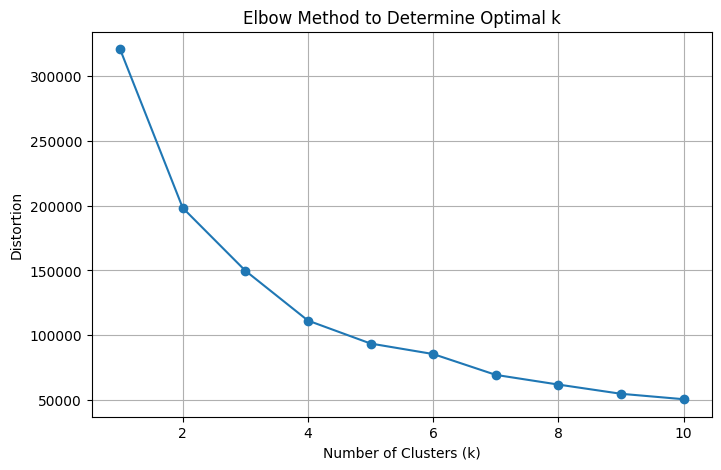

In [9]:
# Step 4: Elbow method
elbow_method(normalized_data, columns)

### Elbow Method Analysis:

Based on the elbow method results, we observe the following:

- **WCSS values**:
  - Cluster 1: 300,000
  - Cluster 2: 200,000
  - Cluster 3: 150,000
  - Cluster 4: 120,000
  - Cluster 5: 90,000
  - Cluster 6: 80,000
  - Cluster 10: 50,000

### Key Observations:
1. **Gradual Decrease**: From Cluster 1 to Cluster 6, the WCSS decreases gradually, indicating that as the number of clusters increases, the variance within clusters is reduced.
2. **Sharp Decrease**: After Cluster 6, there is a sharper drop in WCSS (to 50,000 at Cluster 10), suggesting that adding more clusters helps in explaining the variance but with diminishing returns.

### Conclusion:
The optimal number of clusters seems to be **Cluster 4** or **Cluster 5**, where the rate of decrease in WCSS begins to slow down significantly. This suggests that increasing the number of clusters beyond this point doesn't provide substantial improvement in reducing WCSS.

Hence, I recommend using **Cluster 4** as the optimal number of clusters for this dataset.


d:\Desktop\Tellco-Profitability-Analysis\scripts\user_engagement_analysis.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_traffic', y='Application', data=top_apps, palette='viridis')


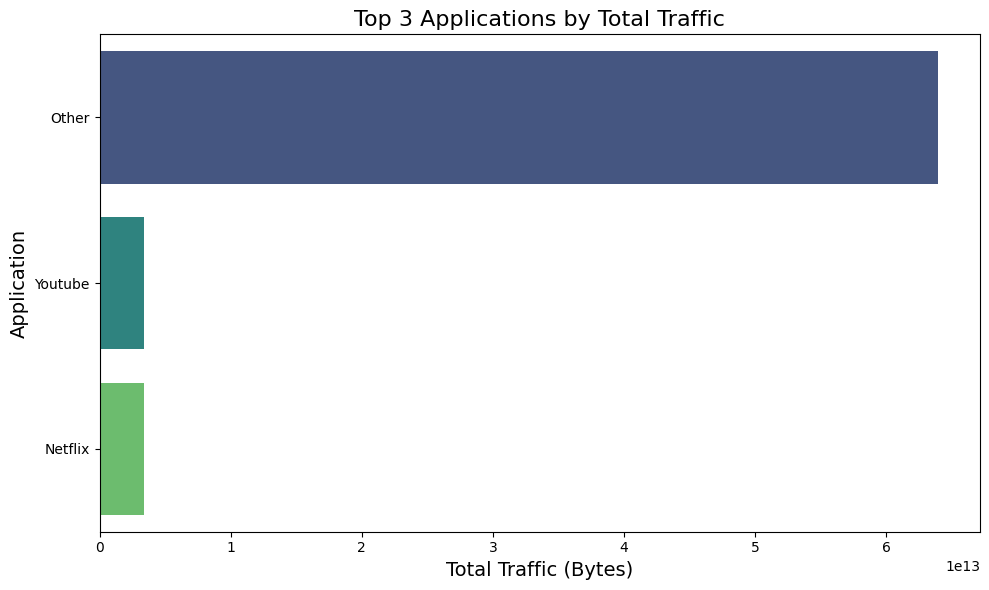

In [5]:
# Step 5: Application traffic aggregation and plotting
app_traffic = aggregate_traffic_per_application(data)

# Get the top 10 customers with the highest traffic
top_10_app_users = top_n_customers(app_traffic, 'total_traffic', n=10)

# Plot the top 3 applications with the highest total traffic



### Traffic Distribution Analysis

The analysis shows that the "Other" category significantly leads in total traffic, followed by YouTube and Netflix. The "Other" category likely represents unclassified traffic or applications not covered in our current dataset. It is important to note that the large share of traffic attributed to "Other" indicates that a substantial portion of user activity is coming from unidentified or miscellaneous sources. Further investigation and more granular data collection would be necessary to better classify this traffic.

#### Key Observations:
- **Other**: Represents the largest share of total traffic, likely coming from miscellaneous or unclassified applications.
- **YouTube**: The second-largest contributor to traffic, aligning with trends in data usage for content-heavy platforms.
- **Netflix**: Follows closely behind YouTube in traffic consumption, emphasizing the prevalence of streaming services.

### Conclusion:
Given the dominance of "Other" in the data, it is crucial to explore further classification or gather additional data to understand the sources behind this traffic. In contrast, YouTube and Netflix's significant contributions highlight the importance of optimizing for streaming services, which are the main drivers of bandwidth consumption.
